# CABXD plots on AlaD Replicas with all heavy atoms
**Zilin Song, 20231228**

## Imports

In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, matplotlib
sns.set_style('ticks')
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 8.

from itertools import combinations

## Loaders: path evolution

In [2]:
evol_wkdir = './0_path_evolution'
evol_phi_indices = [0, 1, 2, 3]
evol_psi_indices = [1, 2, 3, 4]


def get_path_colvar(i_optim: int) -> np.ndarray:
  """Get the CAR constrained path colvar on the i_optim-th run."""
  return np.load(f'{evol_wkdir}/pathopt_{i_optim}/path_colvar.npy')


def get_path_replica_trajectory(i_optim: int, i_replica: int) -> np.ndarray:
  """Return the Replica trajectory at the i_optim-th optimization cycle and the i_replica-th Replica."""
  return np.load(f'{evol_wkdir}/pathopt_{i_optim}/sampler{i_replica}_traj.npz')['replica_coords']


def get_dihedrals(coordinates: np.ndarray, atom_indices: list[int]):
  """Return the dihedrals defined by 4-member atom_indices from coordinates."""

  def compute_dihedral(p0:np.ndarray, p1:np.ndarray, 
                       p2:np.ndarray, p3:np.ndarray):
    """Compute the dihedral between four Cartesian points: p0, p1, p2, p3."""
    B0, B1, B2 = p1 - p0, p2 - p1, p3 - p2
    cos =   np.dot(np.cross(B0, B1), np.cross(B1, B2))                  \
          / np.linalg.norm(np.cross(B0, B1))                            \
          / np.linalg.norm(np.cross(B1, B2))
    sin =   np.dot(np.cross(np.cross(B0, B1), np.cross(B1, B2)), B1)    \
          / np.linalg.norm(np.cross(B0, B1))                            \
          / np.linalg.norm(np.cross(B1, B2))                            \
          / np.linalg.norm(B1)
    return np.arctan2(sin, cos)
  
  dihedrals = []

  for coordinate in range(coordinates.shape[0]):
    cartesian = coordinates[coordinate, :].reshape(-1, 3)
    dihedrals.append(compute_dihedral(cartesian[atom_indices[0], :], cartesian[atom_indices[1], :], 
                                      cartesian[atom_indices[2], :], cartesian[atom_indices[3], :], 
                                      ) / np.pi * 180. )
  
  return np.asarray(dihedrals)

## cbar

(31,)


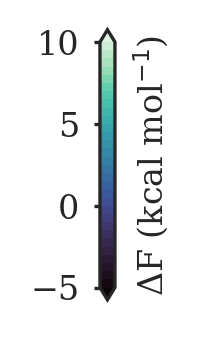

In [3]:
import matplotlib
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(.5, 2.3), dpi=300)
plt.subplots_adjust(left=.25/.5, right=.3/.5, top=1.7/2.3, bottom=.8/2.3)

ax.set(yticks=[-5, 0, 5, 10],)

cmap=sns.color_palette('mako', as_cmap=True)
bounds = np.arange(-5, 10.1, .5)
print(bounds.shape)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='both')

cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, extend='both')
cb.set_label(label=r'ΔF (kcal mol$^{-1}$)')
cb.ax.minorticks_off()
cb.ax.set(yticks=[-5, 0, 5, 10])
cb.ax.tick_params(length=1.5)
cb.ax.yaxis.set_ticks_position('left')
fig.savefig(f'./figures/alad0_path_evolution_cbar.jpeg')

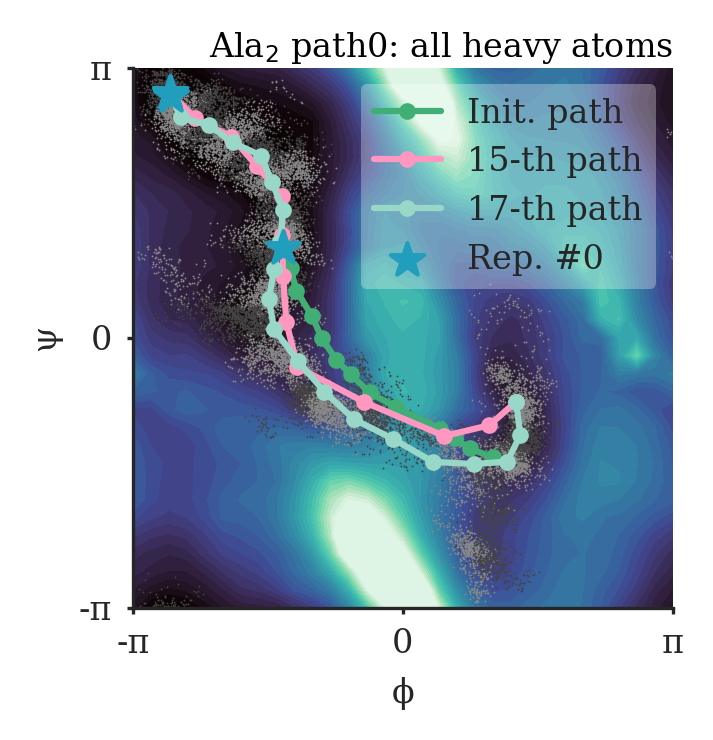

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.3, 2.4), dpi=300)

ax.set(xlim=(-180, 180), xticks=(-180, 0, 180), xlabel=r"ϕ", xticklabels=["-π", 0, "π"],
       ylim=(-180, 180), yticks=(-180, 0, 180), ylabel=r"ψ", yticklabels=["-π", 0, "π"], )

alad_fes = np.load('../../examples/alad_c36m/fes/fes.npz')
ax.contourf(alad_fes['phi_degs'], alad_fes['psi_degs'], alad_fes['energies'], 
            levels=np.linspace(-5, 10, 31), extend='both', cmap=sns.color_palette("mako", as_cmap=True))

for i_replica in range(20):
  traj = get_path_replica_trajectory(i_optim=19, i_replica=i_replica)
  ax.scatter(get_dihedrals(coordinates=traj, atom_indices=evol_phi_indices), 
             get_dihedrals(coordinates=traj, atom_indices=evol_psi_indices), 
             s=.2, linewidths=0., c='#444444' if i_replica % 2 == 0 else '#888888', zorder=1)
  
path_colvar = get_path_colvar(i_optim=0)
ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
        get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
        c='#41ae76', marker='.', label='Init. path')

path_colvar = get_path_colvar(i_optim=15)
ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
        get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
        c="#ff97c1", marker='.', label='15-th path')


# path_colvar = get_path_colvar(i_optim=15)
# ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
#         get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
#         c="#99d8c9", ls='--', marker='.', markersize=8,  zorder=11, label='15-th Path', lw=1.)

# path_colvar = get_path_colvar(i_optim=16)
# ax.scatter(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices)[[9, 10, 11, 13, 14, 15, 17]], 
#            get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices)[[9, 10, 11, 13, 14, 15, 17]], 
#            c='#41ae76', s=30, marker='D', linewidths=0., zorder=15, label='Interpolated')

path_colvar = get_path_colvar(i_optim=18)
ax.plot(get_dihedrals(coordinates=path_colvar, atom_indices=evol_phi_indices), 
        get_dihedrals(coordinates=path_colvar, atom_indices=evol_psi_indices), 
        c="#99d8c9", marker='.', label='17-th path')

ax.scatter([get_dihedrals(coordinates=get_path_colvar(i_optim=_)[0][np.newaxis, :], atom_indices=evol_phi_indices) for _ in [0, 5, 10, 18]],
           [get_dihedrals(coordinates=get_path_colvar(i_optim=_)[0][np.newaxis, :], atom_indices=evol_psi_indices) for _ in [0, 5, 10, 18]],
           c="#219ebc", marker='*', s=70, zorder=11, label='Rep. #0')

ax.text(x=180, y=205, s=r'Ala$_2$ path0: all heavy atoms', ha='right', va='top', c='#000000')

ax.set_aspect('equal', adjustable='box')
ax.tick_params(length=1.5)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), framealpha=0.3).get_frame().set_linewidth(0.)
sns.despine()
plt.subplots_adjust(left=.4/2.3, right=2.2/2.3, top=2.2/2.4, bottom=.4/2.4)
plt.savefig('./figures/alad0_path_evolution.png')

## Path evolution convergence

1 0.000, 0.084, 0.149, 0.217, 0.288, 0.324, 0.366, 0.488, 0.544, 0.515, 0.347, 0.207, 0.315, 0.338, 0.238, 0.314, 0.227, 0.218, 0.144, 0.000 -- 0.266
2 0.000, 0.022, 0.024, 0.033, 0.044, 0.037, 0.028, 0.063, 0.047, 0.081, 0.108, 0.072, 0.066, 0.033, 0.082, 0.065, 0.059, 0.019, 0.044, 0.000 -- 0.046


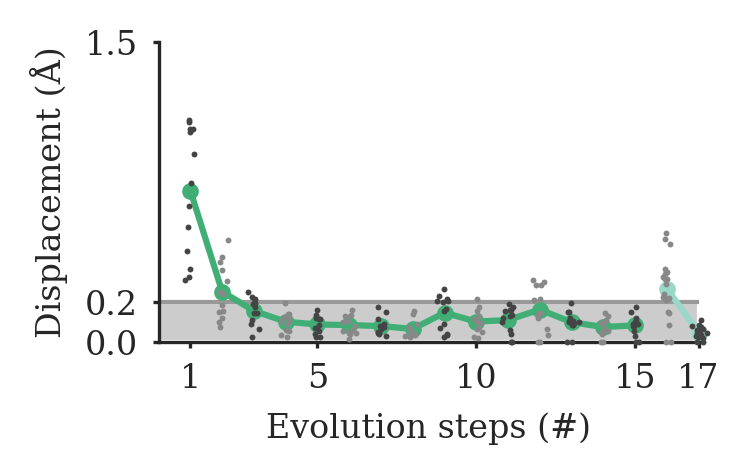

In [5]:
import sys, os
sys.dont_write_bytecode=True
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

from pycospath.utils.geometry import getfn_get_weighted_aligned, getfn_get_rowwise_weighted_rms
get_aligned = getfn_get_weighted_aligned(method_alignment='kabsch', weight_per_dof=np.ones((30, )))
get_row_rms = getfn_get_rowwise_weighted_rms(weight_per_dof=np.ones((30, )), num_dofs_per_atom=3)

# 13-replicas paths.
path13_disp = np.zeros((15, 13))
path13_mean = np.zeros((15, ))

for i_optim in range(1, 16):
  path_colvar0 = get_path_colvar(i_optim=i_optim-1)
  path_colvar1 = get_path_colvar(i_optim=i_optim  )

  for i_replica in range(13):
    replica_colvar0 = np.copy(path_colvar0[i_replica, :])
    replica_colvar1 = np.copy(path_colvar1[i_replica, :])
    replica_colvar1_aligned = get_aligned(array_to_refer=replica_colvar0, 
                                          array_to_align=replica_colvar1, )
    path13_disp[i_optim-1, i_replica] = get_row_rms(array0=replica_colvar0        [np.newaxis, :], 
                                                    array1=replica_colvar1_aligned[np.newaxis, :], )[0]
  
  path13_mean[i_optim-1] = np.mean(path13_disp[i_optim-1, :])

# 20-replicas paths.
num_iterations = 2
path20_disp = np.zeros((num_iterations, 20))
path20_mean = np.zeros((num_iterations, ))

for i_optim in range(17, 17+num_iterations):
  path_colvar0 = get_path_colvar(i_optim=i_optim-1)
  path_colvar1 = get_path_colvar(i_optim=i_optim  )

  for i_replica in range(20):
    replica_colvar0 = np.copy(path_colvar0[i_replica, :])
    replica_colvar1 = np.copy(path_colvar1[i_replica, :])
    replica_colvar1_aligned = get_aligned(array_to_refer=replica_colvar0, 
                                          array_to_align=replica_colvar1, )
    path20_disp[i_optim-17, i_replica] = get_row_rms(array0=replica_colvar0       [np.newaxis, :], 
                                                    array1=replica_colvar1_aligned[np.newaxis, :], )[0]
  
  path20_mean[i_optim-17] = np.mean(path20_disp[i_optim-17, :])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.4, 1.5), dpi=300)

ax.set(xlim=(0., 17  ), xticks=(1, 5, 10, 15, 17,),  xlabel=r'Evolution steps (#)', 
       ylim=(0.,  1.25), yticks=(0., .2, 1.5), ylabel=r'Displacement (Å)', )

from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((0, 0), 17, .2, facecolor='#cccccc'))
ax.plot([.0, 17], [.2, .2], '#999999', clip_on=True, lw=1, zorder=1)
ax.plot(np.arange(15)+1,              path13_mean, c="#41ae76", marker='.', clip_on=False)
ax.plot(np.arange(num_iterations)+16, path20_mean, c="#99d8c9", marker='.', clip_on=False)
  
for i_optim in range(15):
  ax.scatter(np.repeat([i_optim], 13)+np.random.normal(scale=.1, size=13)+1, path13_disp[i_optim, :], 
             s=2., linewidths=0., c='#444444' if i_optim % 2 == 0 else '#888888', zorder=99, clip_on=False)
  
for i_optim in range(num_iterations):
  ax.scatter(np.repeat([i_optim], 20)+np.random.normal(scale=.1, size=20)+16, path20_disp[i_optim, :], 
             s=2., linewidths=0., c='#888888' if i_optim % 2 == 0 else '#444444', zorder=99, clip_on=False)

np.save('./figures/path13_mean.npy', path13_mean)
np.save('./figures/path20_mean.npy', path20_mean)
np.save('./figures/path13_disp.npy', path13_disp)
np.save('./figures/path20_disp.npy', path20_disp)
ax.tick_params(length=1.5)
sns.despine()
plt.subplots_adjust(left=.5/2.4, right=2.3/2.4, top=1.4/1.5, bottom=.4/1.5)
# plt.savefig('./figures/alad0_path_evolution_convergence')

for i in range(path20_disp.shape[0]): print(i+1, ', '.join([str(f'{r:.3f}') for r in path20_disp[i]]), '--', f'{path20_mean[i]:.3f}')


## Loaders: CABXD

In [6]:
from openmm.unit import MOLAR_GAS_CONSTANT_R, kelvin, kilocalorie_per_mole

cabxd_wkdir = './1_path_boxedmd/bxd_statistics'

cabxd_kt = (MOLAR_GAS_CONSTANT_R*350.*kelvin).value_in_unit(kilocalorie_per_mole)

def get_cabxd_voronoi_reflection(i_run: int, i_replica:int) -> np.ndarray:
  """CABXD: get the Voronoi penetration statistics."""
  return np.load(f'{cabxd_wkdir}/run{str(i_run)}_sampler{str(i_replica)}_voronoi_reflection.npz')


def compute_cabxd_transition_kernel(i_run:        int, 
                                    num_replicas: int, 
                                    before_steps: int, 
                                    dycorr_steps: int, 
                                    timestepsize: float, 
                                    ) -> np.ndarray:
  """CABXD: compute the transition kernel from the Voronoi penetration statistics."""
  transition_kernel = np.zeros((num_replicas, num_replicas))
  for i_replica in range(num_replicas):
    voronoi_tape = get_cabxd_voronoi_reflection(i_run=i_run, i_replica=i_replica)
    step_index, cell_index = voronoi_tape['step_index'], voronoi_tape['cell_index']
    step_index, cell_index = step_index[step_index<before_steps], cell_index[step_index<before_steps]
    transition_steps = np.copy(step_index[1:  ]-step_index[0:-1])
    transition_cells = np.copy(cell_index[1:  ]                 )
    dycorr_transition_steps = transition_steps[transition_steps>dycorr_steps]
    dycorr_transition_cells = transition_cells[transition_steps>dycorr_steps]

    for j_to_replica in range(num_replicas):
      if np.abs(j_to_replica-i_replica) > 4: # Reflective boundaries to prebent box-to-far-away-box tunneling.
        transition_kernel[i_replica, j_to_replica] = 0
      else:
        i_to_j_hits = dycorr_transition_cells[dycorr_transition_cells == j_to_replica].shape[0]
        transition_kernel[i_replica, j_to_replica] = i_to_j_hits if i_to_j_hits > 0 else 0 # discard the first hit.

    transition_kernel[i_replica, :] = transition_kernel[i_replica, :] / (1_000_000 * float(timestepsize))# (np.sum(dycorr_transition_steps) * float(timestepsize))
  
  return transition_kernel


def compute_cabxd_stationary_distribution(num_replicas: int, transition_kernel: np.ndarray) -> np.ndarray:
  """CABXD: compute the stationary distribution from the MC kernel."""
  P = np.copy(transition_kernel)
  Q = P - np.identity(num_replicas)*np.sum(P, axis=1)

  Q1 = np.concatenate((Q.T, np.ones((num_replicas, ))[np.newaxis, :]), axis=0)
  y1 = np.concatenate((np.zeros((num_replicas, )), [1]))
  
  Q_, R_ = np.linalg.qr(Q1)
  y = Q_.T @ y1

  return np.linalg.solve(R_, y)


def compute_cabxd_mean_first_passage_time(to_replica: int, 
                                          num_replicas:int, 
                                          transition_kernel: np.ndarray, 
                                          ) -> np.ndarray:
  """CABXD: compute the mean first passage time to the to_replica-th replica from the MC kernel."""
  P = np.copy(transition_kernel)
  Q = P - np.identity(num_replicas)*np.sum(P, axis=1)

  # Remove to_replica rows and cols.
  idx = np.arange(num_replicas)
  Qhat = Q[idx!=to_replica, :][:, idx!=to_replica]

  # Solve for MFPTs
  mfpts = np.zeros((num_replicas, ))
  mfpts_to_replica = np.linalg.solve(Qhat, -np.ones((num_replicas-1, )))

  mfpts[idx!=to_replica] = mfpts_to_replica
  
  return mfpts

cabxd_kt

0.695521490524291

## CABXD free energy profile

[-1.11022302e-16  3.19819235e-01  6.11297077e-01  7.95223505e-01
  9.91826104e-01  1.17327046e+00  1.20507091e+00  1.12134210e+00
  1.58772138e+00  1.72530174e+00  1.87741167e+00  3.47271363e+00
  4.81632976e+00  7.76499496e+00  9.94346361e+00  6.27529492e+00
  4.37490709e+00  3.36683267e+00  2.83181137e+00  2.67762692e+00] 

 [0.01005451 0.00478115 0.00790401 0.00770192 0.01227032 0.01177841
 0.012617   0.01096284 0.01522122 0.02019372 0.01943928 0.02008155
 0.02029956 0.04151124 0.03715651 0.09332308 0.09225183 0.10209791
 0.0988276  0.09505905]


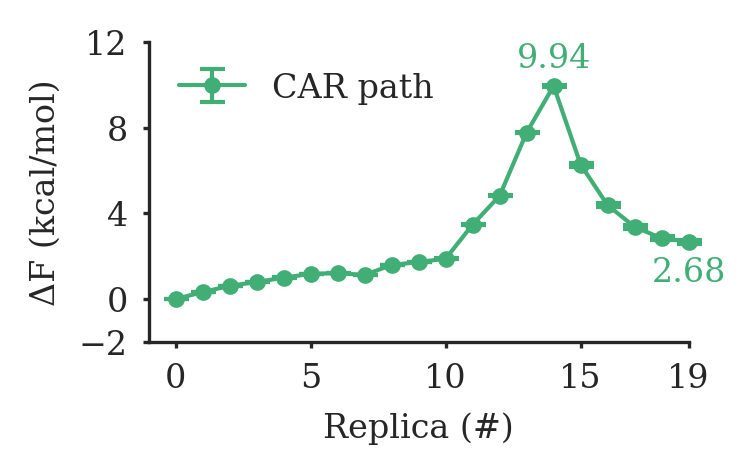

In [7]:
num_runs, num_replicas, before_steps, dycorr_steps, timestepsize = 5, 20, np.inf, 0, .001
batch_idx = np.asarray(list(combinations(range(num_runs), 3)))

bxd_transmats = np.zeros((num_runs, num_replicas, num_replicas))
bxd_fes = np.zeros((batch_idx.shape[0], num_replicas))

for i_run in range(num_runs):
  bxd_transmats[i_run, :, :] = compute_cabxd_transition_kernel(i_run=i_run, 
                                                               num_replicas=num_replicas, 
                                                               before_steps=before_steps, 
                                                               dycorr_steps=dycorr_steps, 
                                                               timestepsize=timestepsize, )
  
for i_trial in range(batch_idx.shape[0]):
  bxd_fes[i_trial, :] = compute_cabxd_stationary_distribution(num_replicas=num_replicas, 
                                                              transition_kernel=np.mean(bxd_transmats[batch_idx[i_trial], :, :], axis=0), )

bxd_fes = -np.log(np.abs(bxd_fes)) * cabxd_kt
bxd_fes -= np.mean(bxd_fes, axis=0)[0]

fe_mean = np.mean(bxd_fes, axis=0)
fe_95ci = np.std (bxd_fes, axis=0) / np.sqrt(10) * 1.96
print(fe_mean, '\n\n', fe_95ci)

np.save('./figures/fe_mean.npy', fe_mean)
np.save('./figures/fe_95ci.npy',  fe_95ci)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5, 1.5), dpi=300)

ax.errorbar(x=np.arange(20), y=fe_mean, yerr=np.asarray([fe_95ci]),
            c='#41ae76', marker='.', label='CAR path', lw=1., capsize=3., ecolor='#41ae76', clip_on=False)

ax.text(x=14, y=10.5, s=f'{np.round(fe_mean[14], 2):.2f}', ha='center', va='bottom', c='#41ae76')
ax.text(x=19, y=  .5, s=f'{np.round(fe_mean[-1], 2):.2f}', ha='center', va='bottom', c='#41ae76')

ax.set(xlim=(-1, 19), xlabel=r'Replica (#)',   xticks=[0, 5, 10, 15, 19],
       ylim=(-2, 12), ylabel=r'ΔF (kcal/mol)', yticks=[-2, 0, 4, 8, 12], )

# ax.legend(frameon=False, fontsize=7.)
ax.tick_params(length=1.5)
sns.despine()
plt.subplots_adjust(left=.5/2.5, right=2.3/2.5, top=1.4/1.5, bottom=.4/1.5)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), framealpha=0.3).get_frame().set_linewidth(0.)
# plt.savefig('./figures/alad0_free_energies.png')

## CABXD end-to-end MFPTs

In [9]:
bxd_mfpts = bxd_mfptmat[:, 0, -1] # unit: ps
print(bxd_mfpts.shape)
mean_bxd_mfpts = np.mean(bxd_mfpts, axis=0)

print('\nMFPTs:')
print(f' BXD: {mean_bxd_mfpts:>8.2f} 95ci. {np.std(bxd_mfpts)/np.sqrt(10)*1.96:<8.2f} ps')

(10,)

MFPTs:
 BXD: 2489454.84 95ci. 152013.66 ps
